# LOGO CLASSIFICATION



In [1]:
# Import the basic required utilities and layers
import numpy as np
import os

# Import the required utilities and it layers to load and preprocess the image data
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

# Import the utilities to effective find the paths and list the images
import pathlib

# Import keras uitilities
# from tensorflow import keras
from tensorflow.keras import layers

In [2]:
#keras

In [3]:
data_dir = pathlib.Path("C:\\DataScience\\ADC\\clothdata1\\Train")

In [4]:
print(data_dir)

C:\DataScience\ADC\clothdata1\Train


In [5]:
# NOT NEEDED
# print(data_dir.parts)

In [6]:
dirs = [e for e in data_dir.iterdir() if e.is_dir()]
print(dirs)
print (type(dirs))

[WindowsPath('C:/DataScience/ADC/clothdata1/Train/Addidas'), WindowsPath("C:/DataScience/ADC/clothdata1/Train/Birki's"), WindowsPath('C:/DataScience/ADC/clothdata1/Train/Brother'), WindowsPath('C:/DataScience/ADC/clothdata1/Train/Hilleberg'), WindowsPath('C:/DataScience/ADC/clothdata1/Train/Husky'), WindowsPath('C:/DataScience/ADC/clothdata1/Train/K-Swiss'), WindowsPath('C:/DataScience/ADC/clothdata1/Train/Pillsbury'), WindowsPath('C:/DataScience/ADC/clothdata1/Train/Salewa'), WindowsPath('C:/DataScience/ADC/clothdata1/Train/Springfield'), WindowsPath('C:/DataScience/ADC/clothdata1/Train/Unicef'), WindowsPath('C:/DataScience/ADC/clothdata1/Train/Vans'), WindowsPath('C:/DataScience/ADC/clothdata1/Train/White Castle')]
<class 'list'>


In [7]:
import os
p=os.listdir(r"C:\DataScience\ADC\clothdata1\Train")
print (type(p))
print (p)
for i in p:
    print(i)

<class 'list'>
['Addidas', "Birki's", 'Brother', 'Hilleberg', 'Husky', 'K-Swiss', 'Pillsbury', 'Salewa', 'Springfield', 'Unicef', 'Vans', 'White Castle']
Addidas
Birki's
Brother
Hilleberg
Husky
K-Swiss
Pillsbury
Salewa
Springfield
Unicef
Vans
White Castle


### NOTE: Later convert the below into functions

57


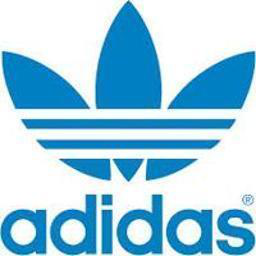

In [8]:

Addidas = list(data_dir.glob('Addidas/*'))
print (len(Addidas))
PIL.Image.open(str(Addidas[1]))

65


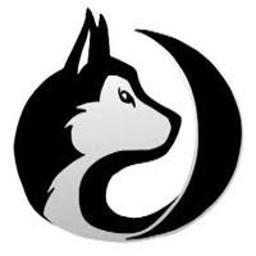

In [9]:
Husky = list(data_dir.glob('Husky/*'))
print (len(Husky))
PIL.Image.open(str(Husky[1]))

#### ********=======******LOAD IMAGES AS DATASETS********=======******

In [10]:
# PARAMETERS FOR THE LOADER

batch_size = 32
img_height = 180
img_width = 180

## Step 1:  Split 80% of the images for training, and 20% for testing (validation)

In [11]:
# Split 80% of the images for training, and 20% for testing (validation)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)



Found 643 files belonging to 12 classes.
Using 515 files for training.


In [12]:
print (train_ds)


<BatchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>


In [13]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 643 files belonging to 12 classes.
Using 128 files for validation.


##  List the class names in the class_names attribute on these datasets.

In [14]:
class_names = train_ds.class_names
print(class_names)

['Addidas', "Birki's", 'Brother', 'Hilleberg', 'Husky', 'K-Swiss', 'Pillsbury', 'Salewa', 'Springfield', 'Unicef', 'Vans', 'White Castle']


### VISUALIZE THE DATA

**The first 9 images from the training dataset**

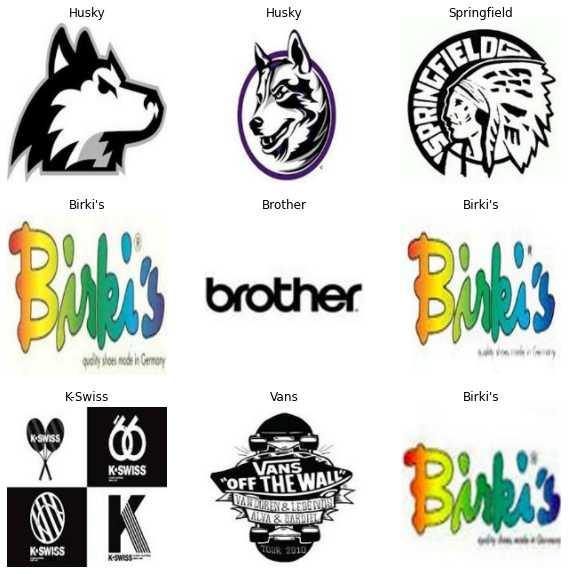

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Manually iterate over the dataset and retrieve batches of images:

In [16]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [17]:
# STANDARDIZE THE DATA

# CURRENT RGB VALUES ARE IN RANGE [0,255]. FOR DEEP LEARNING WE WANT THEM TO BE IN RANGE [0,1]. 
# APPLYING THE RESCALING LAYER FOR FEATURE/IMAGE SCALING

# from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

# map the above normalization layer to the dataset 

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]


In [18]:
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

# the output shows that mean is nearly zero and standard deviation is one now. 
# So z-score is applied properly for feature scaling

0.0 1.0


In [19]:
# Configure the dataset for performance
# .cache() versus .prefetch()
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
print(type(train_ds))
print(type(val_ds))
#print(train_ds.shape)
#print(val_ds.shape)

<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>


In [20]:
# APPLY DATA AUGMENTATION to flip the data in angles. 
from tensorflow.keras.models import Sequential
data_augmentation = Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

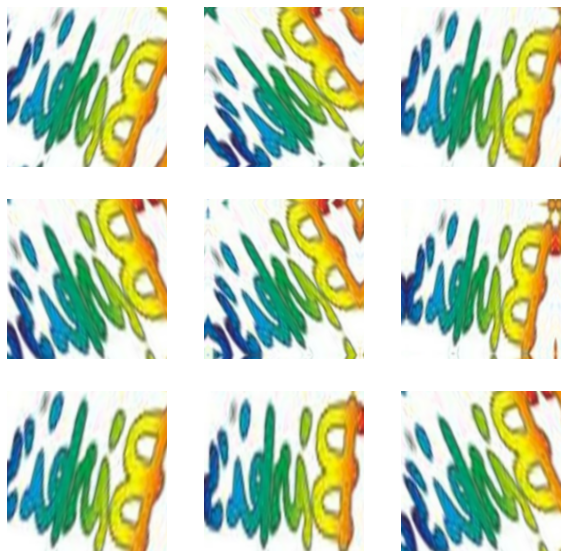

In [21]:
# Check how the data_augmentation images
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

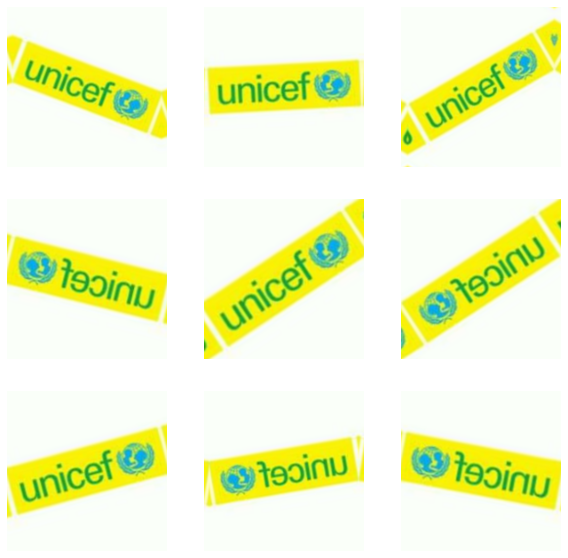

In [22]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

# MODEL TRAINING 
### Using Data Augmentation 
### Using Dropout to reduce overfitting (kind of regularization)
### Using 0.2 for dropsout 20% of the output units created above. 

In [23]:
# # CREATE THE MODEL
# 3 CONVOLUTION BLOCKS FOR A STANDARD APPROACH TO SEE  HOW THIS ALL BEHAVES
#from tensorflow.keras.models import Sequential
# Have used the 

num_classes = 12

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [24]:
# Compile the model

model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)       

In [26]:
# Train for few epochs

epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
17/17 [==============================] - 10s 515ms/step - loss: 3.5512 - accuracy: 0.0972 - val_loss: 2.3673 - val_accuracy: 0.1484
Epoch 2/20
17/17 [==============================] - 8s 445ms/step - loss: 2.2421 - accuracy: 0.2193 - val_loss: 1.8981 - val_accuracy: 0.3828
Epoch 3/20
17/17 [==============================] - 8s 450ms/step - loss: 1.7765 - accuracy: 0.4306 - val_loss: 1.4741 - val_accuracy: 0.5391
Epoch 4/20
17/17 [==============================] - 8s 465ms/step - loss: 1.4352 - accuracy: 0.5228 - val_loss: 1.2970 - val_accuracy: 0.5938
Epoch 5/20
17/17 [==============================] - 8s 467ms/step - loss: 1.1907 - accuracy: 0.6164 - val_loss: 1.1167 - val_accuracy: 0.6406
Epoch 6/20
17/17 [==============================] - 8s 497ms/step - loss: 1.0165 - accuracy: 0.6484 - val_loss: 1.1502 - val_accuracy: 0.6328
Epoch 7/20
17/17 [==============================] - 8s 485ms/step - loss: 0.9313 - accuracy: 0.7191 - val_loss: 1.3218 - val_accuracy: 0.6250
Epoch

In [27]:
# VISUALIZE TRAINING RESULTS

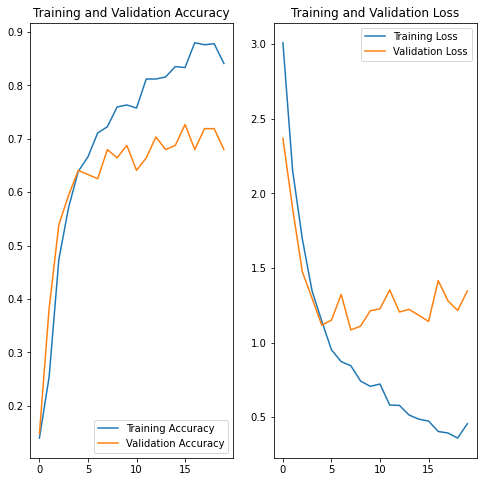

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [34]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

#Print the Target names



target_names = []
for key in train_generator.class_indices:
    target_names.append(key)



# print(target_names)


#Confution Matrix 

y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')



#Print Classification Report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))



#Save the model
model.save("tutorial.hdf5")



#Test the model
img_rows = 250
img_cols = 250

model = load_model('tutorial.hdf5')
file = 'sample.jpg'

img = cv.cvtColor(cv.imread(file),cv.COLOR_BGR2RGB)
img = cv.resize(img, (img_rows,img_cols))
test_image = image.img_to_array(img)
test_image = np.expand_dims(test_image, axis=0)
pred = model.predict(test_image)
print(pred, labels[np.argmax(pred)])
    

NameError: name 'train_generator' is not defined

In [29]:
# TEST THE MODEL
#from keras.preprocessing import image
# Test path for each image C:\Users\Admin\Desktop\ClothTestFolder

validate_image_dir = pathlib.Path("C:\\Users\\Admin\\Desktop\\ClothTestFolder\\")
image_file_list = list(validate_image_dir.glob('*'))

# puma_url = "http://3.bp.blogspot.com/-eGxZHpshFcg/URxxonUCcfI/AAAAAAAAAN0/jvsnB1BHi9s/s1600/Logo+Puma+7.jpg"
# puma_path = tf.keras.utils.get_file('puma_img', origin=puma_url)
# img = tf.keras.preprocessing.image.load_img(puma_path, target_size=(img_height, img_width) )

for i in range(len(image_file_list)):
    print (image_file_list[i])
    img = tf.keras.preprocessing.image.load_img(image_file_list[i], target_size=(img_height, img_width) )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    print("This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score)))
    print ("\n")

C:\Users\Admin\Desktop\ClothTestFolder\addidas_0.jpg
This image most likely belongs to Addidas with a 99.93 percent confidence.


C:\Users\Admin\Desktop\ClothTestFolder\addidas_1.jpg
This image most likely belongs to Addidas with a 99.09 percent confidence.


C:\Users\Admin\Desktop\ClothTestFolder\addidas_10.jpg
This image most likely belongs to Addidas with a 71.81 percent confidence.


C:\Users\Admin\Desktop\ClothTestFolder\addidas_12.jpg
This image most likely belongs to Addidas with a 91.41 percent confidence.


C:\Users\Admin\Desktop\ClothTestFolder\addidas_13.jpg
This image most likely belongs to Addidas with a 99.78 percent confidence.


C:\Users\Admin\Desktop\ClothTestFolder\addidas_14.jpg
This image most likely belongs to Addidas with a 99.99 percent confidence.


C:\Users\Admin\Desktop\ClothTestFolder\addidas_15.jpg
This image most likely belongs to Addidas with a 99.96 percent confidence.


C:\Users\Admin\Desktop\ClothTestFolder\addidas_16.jpg
This image most likely belongs 

This image most likely belongs to Brother with a 96.86 percent confidence.


C:\Users\Admin\Desktop\ClothTestFolder\Brother_20.jpg
This image most likely belongs to Brother with a 75.91 percent confidence.


C:\Users\Admin\Desktop\ClothTestFolder\Brother_3.jpg
This image most likely belongs to Brother with a 89.31 percent confidence.


C:\Users\Admin\Desktop\ClothTestFolder\Brother_4.jpg
This image most likely belongs to Brother with a 47.91 percent confidence.


C:\Users\Admin\Desktop\ClothTestFolder\Brother_5.jpg
This image most likely belongs to Brother with a 92.82 percent confidence.


C:\Users\Admin\Desktop\ClothTestFolder\Brother_6.jpg
This image most likely belongs to Brother with a 98.50 percent confidence.


C:\Users\Admin\Desktop\ClothTestFolder\Brother_7.jpg
This image most likely belongs to Brother with a 87.60 percent confidence.


C:\Users\Admin\Desktop\ClothTestFolder\Brother_8.jpg
This image most likely belongs to Brother with a 91.52 percent confidence.


C:\Users\Adm

This image most likely belongs to Vans with a 65.93 percent confidence.


C:\Users\Admin\Desktop\ClothTestFolder\K-Swiss_5.jpg
This image most likely belongs to K-Swiss with a 32.56 percent confidence.


C:\Users\Admin\Desktop\ClothTestFolder\K-Swiss_6.jpg
This image most likely belongs to Springfield with a 81.59 percent confidence.


C:\Users\Admin\Desktop\ClothTestFolder\K-Swiss_7.jpg
This image most likely belongs to Springfield with a 50.92 percent confidence.


C:\Users\Admin\Desktop\ClothTestFolder\K-Swiss_8.jpg
This image most likely belongs to Vans with a 56.62 percent confidence.


C:\Users\Admin\Desktop\ClothTestFolder\K-Swiss_9.jpg
This image most likely belongs to K-Swiss with a 75.17 percent confidence.


C:\Users\Admin\Desktop\ClothTestFolder\pillsbury_0.jpg
This image most likely belongs to Pillsbury with a 100.00 percent confidence.


C:\Users\Admin\Desktop\ClothTestFolder\pillsbury_1.jpg
This image most likely belongs to Pillsbury with a 100.00 percent confidence.


C

This image most likely belongs to Springfield with a 52.35 percent confidence.


C:\Users\Admin\Desktop\ClothTestFolder\Springfield_5.jpg
This image most likely belongs to Vans with a 95.15 percent confidence.


C:\Users\Admin\Desktop\ClothTestFolder\Springfield_6.jpg
This image most likely belongs to Springfield with a 62.81 percent confidence.


C:\Users\Admin\Desktop\ClothTestFolder\Springfield_7.jpg
This image most likely belongs to Husky with a 58.07 percent confidence.


C:\Users\Admin\Desktop\ClothTestFolder\Springfield_8.jpg
This image most likely belongs to Springfield with a 99.53 percent confidence.


C:\Users\Admin\Desktop\ClothTestFolder\Springfield_9.jpg
This image most likely belongs to Husky with a 89.75 percent confidence.


C:\Users\Admin\Desktop\ClothTestFolder\Unicef_0.jpg
This image most likely belongs to Pillsbury with a 99.54 percent confidence.


C:\Users\Admin\Desktop\ClothTestFolder\Unicef_1.jpg
This image most likely belongs to Unicef with a 98.69 percent con

This image most likely belongs to Addidas with a 27.73 percent confidence.


C:\Users\Admin\Desktop\ClothTestFolder\White Castle_26.jpg
This image most likely belongs to White Castle with a 100.00 percent confidence.


C:\Users\Admin\Desktop\ClothTestFolder\White Castle_3.jpg
This image most likely belongs to White Castle with a 99.98 percent confidence.


C:\Users\Admin\Desktop\ClothTestFolder\White Castle_4.jpg
This image most likely belongs to White Castle with a 96.03 percent confidence.


C:\Users\Admin\Desktop\ClothTestFolder\White Castle_5.jpg
This image most likely belongs to White Castle with a 99.93 percent confidence.


C:\Users\Admin\Desktop\ClothTestFolder\White Castle_6.jpg
This image most likely belongs to White Castle with a 99.99 percent confidence.


C:\Users\Admin\Desktop\ClothTestFolder\White Castle_7.jpg
This image most likely belongs to White Castle with a 99.97 percent confidence.


C:\Users\Admin\Desktop\ClothTestFolder\White Castle_8.jpg
This image most likely 

In [30]:
model.save('model.h5')

In [31]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image




In [32]:
# TEST THE MODEL
#from keras.preprocessing import image
# Test path for each image C:\Users\Admin\Desktop\ClothTestFolder

validate_image_dir = pathlib.Path("C:\\Users\\Admin\\Desktop\\ClothTestFolder\\")
image_file_list = list(validate_image_dir.glob('*'))

# puma_url = "http://3.bp.blogspot.com/-eGxZHpshFcg/URxxonUCcfI/AAAAAAAAAN0/jvsnB1BHi9s/s1600/Logo+Puma+7.jpg"
# puma_path = tf.keras.utils.get_file('puma_img', origin=puma_url)
# img = tf.keras.preprocessing.image.load_img(puma_path, target_size=(img_height, img_width) )
validated_True = 0
validated_False = 0 
for i in range(len(image_file_list)):
    #print (image_file_list[i])
    image_name = os.path.basename(image_file_list[i])   
    format_image_name = image_name.split("_")
    test_image_name = format_image_name[0]
    print (test_image_name)
    
    
    img = tf.keras.preprocessing.image.load_img(image_file_list[i], target_size=(img_height, img_width) )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    print("This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score)))
    print (class_names[np.argmax(score)])
    
    if (test_image_name == class_names[np.argmax(score)].lower()):
        validated_True =+ 1
        print ("True")
     
    else:
        validated_False =+ 1
        print ("False")
    
        
    print ("\n")
    
print ("Total images correctly validated : ", validated_True) 
print ("Total images incorrectly validated : ", validated_False) 
    

addidas
This image most likely belongs to Addidas with a 99.93 percent confidence.
Addidas
True


addidas
This image most likely belongs to Addidas with a 99.09 percent confidence.
Addidas
True


addidas
This image most likely belongs to Addidas with a 71.81 percent confidence.
Addidas
True


addidas
This image most likely belongs to Addidas with a 91.41 percent confidence.
Addidas
True


addidas
This image most likely belongs to Addidas with a 99.78 percent confidence.
Addidas
True


addidas
This image most likely belongs to Addidas with a 99.99 percent confidence.
Addidas
True


addidas
This image most likely belongs to Addidas with a 99.96 percent confidence.
Addidas
True


addidas
This image most likely belongs to Addidas with a 97.35 percent confidence.
Addidas
True


addidas
This image most likely belongs to Addidas with a 99.89 percent confidence.
Addidas
True


addidas
This image most likely belongs to Addidas with a 100.00 percent confidence.
Addidas
True


addidas
This image 

This image most likely belongs to Hilleberg with a 98.18 percent confidence.
Hilleberg
False


Hilleberg
This image most likely belongs to Hilleberg with a 99.74 percent confidence.
Hilleberg
False


Hilleberg
This image most likely belongs to Hilleberg with a 98.99 percent confidence.
Hilleberg
False


Hilleberg
This image most likely belongs to Hilleberg with a 76.06 percent confidence.
Hilleberg
False


Hilleberg
This image most likely belongs to Hilleberg with a 99.89 percent confidence.
Hilleberg
False


Hilleberg
This image most likely belongs to Hilleberg with a 85.04 percent confidence.
Hilleberg
False


Hilleberg
This image most likely belongs to Hilleberg with a 99.88 percent confidence.
Hilleberg
False


Hilleberg
This image most likely belongs to Hilleberg with a 99.88 percent confidence.
Hilleberg
False


Hilleberg
This image most likely belongs to Hilleberg with a 99.84 percent confidence.
Hilleberg
False


Hilleberg
This image most likely belongs to Hilleberg with a 99.1

This image most likely belongs to Salewa with a 99.90 percent confidence.
Salewa
False


Salewa
This image most likely belongs to Salewa with a 99.92 percent confidence.
Salewa
False


Salewa
This image most likely belongs to Salewa with a 99.84 percent confidence.
Salewa
False


Salewa
This image most likely belongs to Salewa with a 99.91 percent confidence.
Salewa
False


Salewa
This image most likely belongs to Salewa with a 99.91 percent confidence.
Salewa
False


Salewa
This image most likely belongs to Salewa with a 99.89 percent confidence.
Salewa
False


Salewa
This image most likely belongs to Salewa with a 99.81 percent confidence.
Salewa
False


Salewa
This image most likely belongs to Salewa with a 90.60 percent confidence.
Salewa
False


Salewa
This image most likely belongs to Salewa with a 99.45 percent confidence.
Salewa
False


Salewa
This image most likely belongs to Salewa with a 99.93 percent confidence.
Salewa
False


Salewa
This image most likely belongs to Salewa

This image most likely belongs to White Castle with a 99.97 percent confidence.
White Castle
False


White Castle
This image most likely belongs to Vans with a 67.98 percent confidence.
Vans
False


White Castle
This image most likely belongs to White Castle with a 99.91 percent confidence.
White Castle
False


White Castle
This image most likely belongs to White Castle with a 99.99 percent confidence.
White Castle
False


White Castle
This image most likely belongs to White Castle with a 99.96 percent confidence.
White Castle
False


White Castle
This image most likely belongs to White Castle with a 99.61 percent confidence.
White Castle
False


White Castle
This image most likely belongs to White Castle with a 64.78 percent confidence.
White Castle
False


White Castle
This image most likely belongs to White Castle with a 99.97 percent confidence.
White Castle
False


White Castle
This image most likely belongs to Addidas with a 27.73 percent confidence.
Addidas
False


White Castle
